In [75]:
import numpy as np
import matplotlib.pyplot as plt


In [76]:
#import data from reading
import ast
def read_data(fileName):

    #Read the file
    f = open(fileName,'r+')
    content = f.readlines()
    f.close()

    #Parse the data
    entry_grid =[] #Concentration levels per data point
    entry_direction = [] #Wind direction per data point
    entry_leak = [] #Leak location per data point

    #Update the above lists for each data point.
    for i in range(len(content)):
        entry = content[i].split(';')
        entry_grid.append( ast.literal_eval(entry[0]))
        entry_direction.append(float(entry[1]))
        entry_leak.append(ast.literal_eval(entry[2]))

    return entry_grid, entry_direction, entry_leak


a,b,c = read_data('data.txt')

grid_data = np.asanyarray(a[0])

In [77]:
grid_data.shape

(101, 101)

In [68]:
M.shape

(101, 101)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


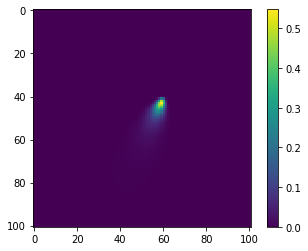

In [78]:
%matplotlib inline
plt.imshow(grid_data);
plt.colorbar()
plt.show()



In [79]:
def readMax(matrix):
    try:
        max_value = np.amax(matrix)
    except:
        max_value = 0
    if max_value == 0:
        return 1,1,0
    else:
        indices = np.where(matrix == max_value)
        return int(indices[0]),int(indices[1]), max_value


In [80]:
class robot():
    '''
    Define a robot class
    grid_size --- The size of the grid on which we place our robot to search for the leak
    '''
    grid_size = 101   #class variable
    def __init__(self, xpos, ypos, reading=0, search_size=1):
        self.x = xpos
        self.y = ypos
        self.reading = reading
        self.search_size = search_size
        self.leak_loc_x = xpos
        self.leak_loc_y = ypos
    def move_up(self):
        if self.x >= 1:
            self.x -= 1
        #else:
            #print("hit the left boundary")

    def move_down(self):
        if self.x < robot.grid_size-1:
            self.x += 1
        #else:
            #print("hit the right boundary")
            
    def move_right(self):
        if self.y < robot.grid_size-1:
            self.y += 1
        #else:
            #print("hit the lower boundary")
    
    def move_left(self):
        if self.y >= 1:
            self.y -= 1
        #else:
            #print("hit the upper boundary")
            
    def search(self,matrix):
        '''
        search the robot's neighbouring girds, record the max value as the current reading and move
        the robot to the position of the max value.
        
        return false if the robot does not move, else return true
        '''
        max_x,max_y, max_value = readMax(matrix)
        if max_value >= self.reading:
            self.reading = max_value

            if max_x == 1 and max_y == 1:
                return False
            else:
                self.x =self.x - 1 + max_x
                self.y =self.y - 1 + max_y
                self.leak_loc_x = self.x
                self.leak_loc_y = self.y

                return True 
            

In [81]:
def assemble_submatrix(matrix, cx, cy, window):
    '''
    form a 3 by 3 submatrix of the given matrix with center at (cx,cy)
    if at the boundary, the size is changed accordingly.
    '''
#     m=matrix.shape[0]
#     n=matrix.shape[1]
    
#     if cx-window<0:
#         sub_x_low = cx
#     else:
#         sub_x_low = cx-window
        
#     if cx+window>=m+1:
#         sub_x_up = cx
#     else:
#         sub_x_up = cx+window+1
        
        
#     if cy-window<0:
#         sub_y_low = cy
#     else:
#         sub_y_low = cy-window
        
#     if cy+window>=n+1:
#         sub_y_up = cy
#     else:
#         sub_y_up = cy+window+1
    sub_x_low, sub_x_up = cx-window, cx+window+1
    sub_y_low, sub_y_up = cy-window, cy+window+1
    submatrix = matrix[sub_x_low:sub_x_up, sub_y_low:sub_y_up]
    return submatrix

In [82]:
def robot_search(matrix, robot):
    '''
    we pad the grid (matrix) with -1 around the boundary, and place the robot at (1,1) instead of (0,0) to start the search
    as a result, the location of the robot (x,y) does not directly correspond to the indices of the gird, rather
    if the robot position index is (i,j), then it actuall cooresponds to (i-1,j-1) on the grid.
    '''
    path = []
    m = matrix.shape[0]
    n = matrix.shape[1]
    padded_matrix = np.pad(matrix, [(1, 1), (1, 1)], mode='constant',constant_values=-1)
    

    for j in range(n):
        #print("y coord", robot.y)
        for i in range(m):
            submatrix = assemble_submatrix(padded_matrix, cx=robot.x,cy=robot.y,window=robot.search_size)
            moved = robot.search(submatrix)                
            if not moved:
                if j%2 == 0:
                    robot.move_down()
                else:
                    robot.move_up()
            path.append((robot.x, robot.y))
        robot.move_right()
        path.append((robot.x, robot.y))
        
        
    return robot.reading, robot.leak_loc_x, robot.leak_loc_y, path

In [83]:
robo=robot(1,1)

In [84]:
del robo
robo = robot(1,1)
max_reading, leak_location_x, leak_location_y, path_data = robot_search(grid_data,robo)

In [85]:
print( 'leak find at (%d, %d)' % (leak_location_x-1, leak_location_y-1) ) 

leak find at (43, 59)


In [86]:
np.argwhere(grid_data == grid_data.max())

array([[43, 59]])

In [87]:
len(path_data)

10302

<IPython.core.display.Javascript object>


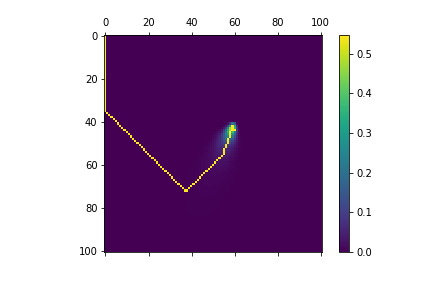

In [93]:
import matplotlib.animation as animation
%matplotlib notebook
#taken from https://stackoverflow.com/questions/41827109/funcanimation-with-a-matrix 

#M=np.zeros((101,101))
M = grid_data.copy()
def update(i):
    x,y = path_data[i]
    M[x-1,y-1] = 1000
    matrice.set_array(M)

fig, ax = plt.subplots()
matrice = ax.matshow(M)
plt.colorbar(matrice)

ani = animation.FuncAnimation(fig, update, frames=125, interval=50)
#ani.save('path.mp4', writer=writer)
ani.save('animation_overlay.gif', writer='imagemagick', fps=20)

plt.show()
